# 라이브러리 버전을 확인해 봅니다
사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import pandas
import konlpy
import gensim
import numpy as np
import tensorflow as tf

import os

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


## 1) 데이터 준비와 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성
실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 ```word_to_index``` 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 ```data_loader```를 만들어 보는 것으로 시작합니다. ```data_loader``` 안에서는 다음을 수행해야 합니다.

* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','모두','어느','모','등','그래서',
            '우선','네','예']#추가해보았다.

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    x_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        x_train.append(temp_X)

    x_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        x_test.append(temp_X)
    
    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))
        
    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index
    
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3) 모델 구성을 위한 데이터 분석 및 가공
* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [6]:
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[32, 73, 914, 4, 4, 39, 227, 20, 33, 743]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


토큰화해서 저장한 Train 데이터들을 decode해서 확인
X_train은 토큰화된 숫자로 이뤄져있습니다. decode해주는 함수를 통해 문장을 확인할 수 있습니다.

In [7]:
decoded_sentences = get_decoded_sentences(x_train, index_to_word)
print(decoded_sentences[0:8])

['더 빙 . . 진짜 짜증 나 네요 목소리', '. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나', '재 ', '이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정', '익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던   너무나 이뻐 보였 다', '  3 세 부터 초등 학교 1 학년 생 인 8 살 용 영화 . ㅋㅋㅋ . .. 별반 개 아까움 .', '긴장감 을 제대로 살려 내 지 못했 다 .', '반개 아깝 다 욕 나온다   연기 생활 몇 년 인지 . . 정말 발 로 해도 그것 보단 낫 겟 다 납치 . 감금 만 반복 반복 . . 드라마 가족 없 다 연기 못 하 사람 만 ']


### PAD, BOS, UNK, UNUSED 를 추가하는 작업을 합니다.
문장의 길이를 맞추면 부족한 부분은 0으로 채워지기 때문입니다.

In [8]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+1) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])# '<BOS>' 가 출력됩니다.
print(index_to_word[2])# UNK
print(index_to_word)

<BOS>
<UNK>
{4: '', 5: '.', 6: '영화', 7: '다', 8: '고', 9: '하', 10: '을', 11: '보', 12: '..', 13: '게', 14: ',', 15: '!', 16: '지', 17: '있', 18: '없', 19: '?', 20: '좋', 21: '나', 22: '었', 23: '만', 24: '는데', 25: '너무', 26: '봤', 27: '적', 28: '안', 29: '정말', 30: '로', 31: '음', 32: '것', 33: '아', 34: '네요', 35: '재밌', 36: '어', 37: '같', 38: '점', 39: '지만', 40: '진짜', 41: '했', 42: '에서', 43: '기', 44: '않', 45: '거', 46: '았', 47: '수', 48: '되', 49: '면', 50: 'ㅋㅋ', 51: '말', 52: '연기', 53: '인', 54: '주', 55: '내', 56: '최고', 57: '~', 58: '평점', 59: '이런', 60: '던', 61: '어요', 62: '할', 63: '왜', 64: '겠', 65: '1', 66: '스토리', 67: '해', 68: '습니다', 69: 'ㅋㅋㅋ', 70: '...', 71: '드라마', 72: '생각', 73: '아니', 74: '더', 75: '그', 76: '싶', 77: '사람', 78: '듯', 79: '때', 80: '감동', 81: '함', 82: '배우', 83: '본', 84: '까지', 85: '뭐', 86: '알', 87: '만들', 88: '내용', 89: '볼', 90: '감독', 91: '보다', 92: '라', 93: '그냥', 94: '재미', 95: '시간', 96: '지루', 97: '중', 98: '재미있', 99: '년', 100: '10', 101: '였', 102: '잼', 103: '사랑', 104: '못', 105: '냐', 106: '재미없', 107: '쓰레기', 10

In [9]:
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 리뷰 라벨

아니 과거   지만 ~~ 좋 아 맨
라벨:  0


In [10]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.89478803515939
문장길이 최대 :  116
문장길이 표준편차 :  12.799416450611947
pad_sequences maxlen :  41
전체 문장의 0.9347800490429459%가 maxlen 설정값 이내에 포함됩니다. 


위의 경우는 maxlen이 41이됨.

In [11]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'혹은 'post'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre' 혹은 'post'
                                                       maxlen=maxlen)

print(x_train.shape)
x_train

(146182, 41)


array([[   0,    0,    0, ...,   20,   33,  743],
       [   0,    0,    0, ...,   15,   43,  389],
       [   0,    0,    0, ...,   24,  204,    3],
       ...,
       [   0,    0,    0, ..., 2703,    6,   18],
       [   0,    0,    0, ...,   59,  393, 8564],
       [   0,    0,    0, ...,   87, 2733,    5]], dtype=int32)

RNN에서는 pre가 더 성능이 좋음.

## train의 일부를 validation으로 나누자
* train, validation을 80:20으로 나누기.

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                          y_train,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=2023)

# 모델 훈련 개시

## LSTM모델

In [13]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 41  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(512))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 512로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 41)          410000    
_________________________________________________________________
lstm (LSTM)                  (None, 512)               1134592   
_________________________________________________________________
dense (Dense)                (None, 8)                 4104      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,548,705
Trainable params: 1,548,705
Non-trainable params: 0
_________________________________________________________________


콜백함수넣기

In [14]:
from keras.callbacks import EarlyStopping
ES=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)

In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,callbacks=[ES],
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 17s 58ms/step - loss: 0.5451 - accuracy: 0.7604 - val_loss: 0.3961 - val_accuracy: 0.8343
Epoch 2/20
229/229 [==============================] - 13s 58ms/step - loss: 0.3488 - accuracy: 0.8511 - val_loss: 0.3492 - val_accuracy: 0.8465
Epoch 3/20
229/229 [==============================] - 13s 58ms/step - loss: 0.3135 - accuracy: 0.8685 - val_loss: 0.3461 - val_accuracy: 0.8482
Epoch 4/20
229/229 [==============================] - 13s 58ms/step - loss: 0.2935 - accuracy: 0.8788 - val_loss: 0.3378 - val_accuracy: 0.8533
Epoch 5/20
229/229 [==============================] - 13s 57ms/step - loss: 0.2740 - accuracy: 0.8871 - val_loss: 0.3394 - val_accuracy: 0.8533
Epoch 6/20
229/229 [==============================] - 13s 56ms/step - loss: 0.2543 - accuracy: 0.8969 - val_loss: 0.3411 - val_accuracy: 0.8519
Epoch 7/20
229/229 [==============================] - 13s 56ms/step - loss: 0.2325 - accuracy: 0.9068 - val_loss: 0.3613 - val_accuracy:

In [16]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.5297 - accuracy: 0.8401
[0.5297124981880188, 0.8401448130607605]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


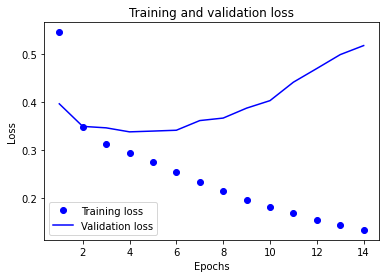

In [17]:
history_dict = history.history
print(history_dict.keys())
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

에폭을 6정도로 주면 좋을것같다.

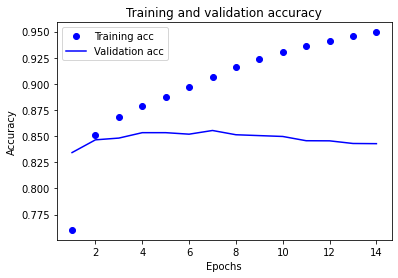

In [18]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

정확도도 train은 점점 잘 맞추는 반면 validation은 평탄하다.

## CNN 적용하기

In [19]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 41  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          4608      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [20]:

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,callbacks=[ES],
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 3s 6ms/step - loss: 0.4657 - accuracy: 0.7738 - val_loss: 0.3535 - val_accuracy: 0.8420
Epoch 2/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3110 - accuracy: 0.8693 - val_loss: 0.3379 - val_accuracy: 0.8505
Epoch 3/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2622 - accuracy: 0.8939 - val_loss: 0.3427 - val_accuracy: 0.8512
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2114 - accuracy: 0.9191 - val_loss: 0.3639 - val_accuracy: 0.8482
Epoch 5/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1582 - accuracy: 0.9435 - val_loss: 0.4113 - val_accuracy: 0.8427
Epoch 6/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1134 - accuracy: 0.9620 - val_loss: 0.4667 - val_accuracy: 0.8418
Epoch 7/20
229/229 [==============================] - 1s 5ms/step - loss: 0.0806 - accuracy: 0.9746 - val_loss: 0.5280 - val_accuracy: 0.8367
Epoch 

확실히 CNN은 속도가 빨랐다.

In [21]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.8478 - accuracy: 0.8244
[0.8478062748908997, 0.824379026889801]


속도가 더빠르고,정확도는 비슷했다.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


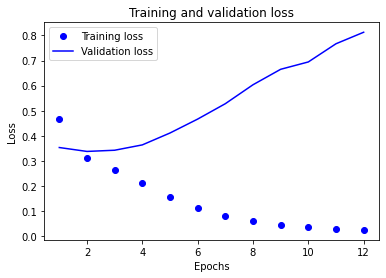

In [22]:
history_dict = history.history
print(history_dict.keys())
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

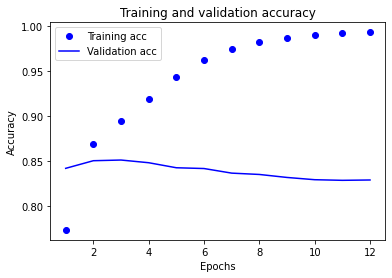

In [23]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

학습될수록 안좋아지는 모델이 되고있습니다.

In [24]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 41)


In [37]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

```gensim```에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용할 수 있습니다.

In [38]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 0.03850364, -0.03516679,  0.02892034,  0.00563104, -0.0711944 ,
       -0.00098909, -0.02952752,  0.09205303,  0.11141989, -0.00297388,
       -0.04762198, -0.02370466,  0.01282556, -0.05196815, -0.0089226 ,
        0.0172822 , -0.05957848,  0.01037282,  0.01862425, -0.04004787,
       -0.11173595,  0.0847195 ,  0.01979644,  0.01881271, -0.00948132,
        0.06755276,  0.08019956,  0.02652857, -0.00576408,  0.05906125,
        0.0292032 , -0.01465304,  0.02351958,  0.02011912,  0.04373376,
        0.01660638, -0.00091134, -0.04874417, -0.05407834, -0.089595  ,
        0.05283201], dtype=float32)

In [39]:
word_vectors.similar_by_word("영화")

[('아', 0.6422265768051147),
 ('연작', 0.6125596761703491),
 ('ㅇ', 0.5831809043884277),
 ('나눠', 0.579252302646637),
 ('업', 0.5668082237243652),
 ('망쳤', 0.5652258396148682),
 ('포커스', 0.5634815096855164),
 ('던', 0.5557606220245361),
 ('지켜라', 0.5495173335075378),
 ('.', 0.5455104112625122)]

유사도를 그렇게 잘찾았다고느끼지는않는다.

그러면 본격적으로 한국어의 Word2Vec 모델을 가져와 적용해 봅시다.

 한국어 Word2Vec 임베딩 활용하여 성능 개선
 
* 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
* 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 
* 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. 
* 참고 https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models, 
* 참고 https://radimrehurek.com/gensim/models/keyedvectors.html

In [53]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_path)
vector = word_vectors.wv['끝']
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

영화랑 비슷한 단어가 어떤 것이 있는지 확인해 보겠습니다.


In [54]:
word_vectors.wv.most_similar("영화")

[('드라마', 0.8418774008750916),
 ('뮤지컬', 0.7775140404701233),
 ('코미디', 0.7489107251167297),
 ('다큐멘터리', 0.7401294708251953),
 ('헐리우드', 0.7397844195365906),
 ('애니메이션', 0.7170552015304565),
 ('독립영화', 0.7113528251647949),
 ('로맨틱', 0.7107657194137573),
 ('장편', 0.7101576924324036),
 ('극영화', 0.7045413255691528)]

엄청난 유사도를 가진것을 알아냈습니다.

In [56]:
# 임베딩 레이어 변경
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 41  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size ):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]
embedding_matrix.shape
#100으로 변경해야 실행이된다.

ValueError: could not broadcast input array from shape (100,) into shape (41,)

위 코드에서 발생한 에러는 워드 벡터의 차원 수가 word_vector_dim 값과 일치하지 않기 때문입니다.

word_vectors.wv[index_to_word[i]]를 통해 가져온 워드 벡터의 차원 수가 100이지만, embedding_matrix의 각 행은 word_vector_dim 값인 41개의 원소로 이루어져 있습니다.

따라서, 워드 벡터의 차원 수를 word_vector_dim 값과 일치하도록 변경해야 합니다. Word2Vec 모델을 학습할 때 워드 벡터의 차원 수를 word_vector_dim 값으로 지정하여 모델을 학습하면 해결됩니다.

In [67]:
# 임베딩 레이어 변경
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size ):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]
embedding_matrix.shape
#100으로 변경해야 실행이된다.

(10000, 100)

In [85]:
# 모델 설계
from tensorflow.keras.initializers import Constant
import keras
vocab_size = 10000   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(512))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 512)               1255424   
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 4104      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 2,259,537
Trainable params: 2,259,537
Non-trainable params: 0
_________________________________________________________________


In [86]:

# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train,
                    y_train,
                    epochs=4,
                    batch_size=512,callbacks=[ES],
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
229/229 [==============================] - 15s 62ms/step - loss: 0.4902 - accuracy: 0.7547 - val_loss: 0.4144 - val_accuracy: 0.8092
Epoch 2/4
229/229 [==============================] - 14s 62ms/step - loss: 0.3612 - accuracy: 0.8387 - val_loss: 0.3562 - val_accuracy: 0.8401
Epoch 3/4
229/229 [==============================] - 14s 62ms/step - loss: 0.3012 - accuracy: 0.8711 - val_loss: 0.3387 - val_accuracy: 0.8520
Epoch 4/4
229/229 [==============================] - 14s 61ms/step - loss: 0.2549 - accuracy: 0.8931 - val_loss: 0.3413 - val_accuracy: 0.8513


In [87]:
# 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3506 - accuracy: 0.8511
[0.35064607858657837, 0.8510690331459045]


모델의 설정을 건들여서 겨우 0.85%의 정확도를 도출하는데 성공했다.

In [88]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


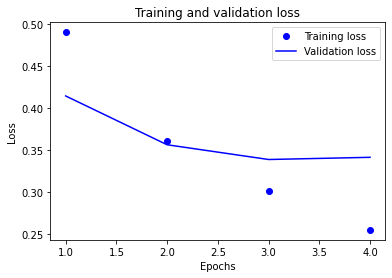

In [89]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

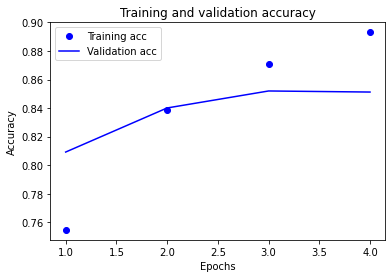

In [90]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

마의 0.85이다. 에폭을 늘려도 여전히0.86으로 넘어서는일은없었다.

# 회고

wv를 넣어서 하는 방법은 검색해서 알아내는 수밖에 없었다. load하는 식은 wv의 기능을 사용했다.

```word_vectors.similar_by_word("영화")```와

```word_vectors.wv.most_similar("영화")```의 뜻은 같다.


이번에 좀 시간을 많이썻고, 단어 임베딩을 만드는법을 알았다.

하지만 학습시킨 임베딩은 무의미한 사전들이 많았다는걸 알았다.

단어임베딩은 미리 학습시킨 데이터로 하는게 좀더 모델의 성능에 도움이 됬다.


* stateful과 stateless에 대해 몰랐을 땐 손님이 계속 이전의 선택지를 이야기 해주기 때문에 손님이 state를 결정한다고 생각했는데 직원이 기억하지 못하여 손님이 선택지를 이야기해주는 것이어서 state를 결정하는 것은 직원이었다.
* RNN 활용 시 pad_sequences의 padding 방식은 post와 pre중 post가 추후 0으로 padding된 부분의 연산을 수행하지 않아도 될 것 같아서 post 방식이 유리할 것으로 예상했지만, 실제로는 RNN의 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치기 때문에 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율 적이라고 한다. 따라서 pre가 훨씬 유리하며 10% 이상의 테스트 성능 차이를 보인다고 한다.
* 정확도를 85%로 올리기 위해 LSTM, 1-D Conv, GlobalMaxPooling 등 다양한 모델에서 각종 하이퍼 파라미터를 이것저것 변화시켜 보았지만 85%는 넘을 수가 없었다. 결국 Word2Vec를 이용하여 Pre-Trained된 Word2Vec Embedding 모델을 사용하였지만 이 모델에서도 유일하게 LSTM 만 85%를 아슬아슬하게 넘을 수 있었다.

좀더 공부해야한다.